In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import pylab as plt

In [2]:
def load_mnist(datadir='./data_cache'):
    train_ds = ds.MNIST(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.MNIST(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0  # [0, 1]
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

X_tr, Y_tr, X_te, Y_te = load_mnist()

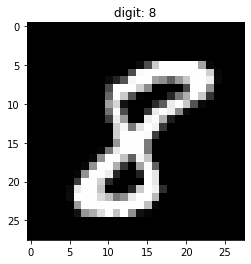

In [3]:
i = np.random.choice(len(X_tr))
plt.imshow(X_tr[i], cmap='gray');
plt.title(f'digit: {Y_tr[i]}');

## Linear Regression

In [4]:
def prepare_reg_data(X, Y, n=None):
    if n is not None:
        I = np.random.choice(len(X), n, replace=False)
        X = X[I]
        Y = Y[I]
    
    Y = (Y % 2) * 2.0 - 1 # odd/even --> +1/-1
    X = X.reshape(-1,  28*28) # flatten

    return X, Y

In [5]:
X_tr_reg, Y_tr_reg = prepare_reg_data(X_tr, Y_tr, 500)
X_te_reg, Y_te_reg = prepare_reg_data(X_te, Y_te)

In [6]:
print('original X_tr:', X_tr.shape)

print('reshaped X:', X_tr_reg.shape)
print('reshaped Y:', Y_tr_reg.shape)

original X_tr: (60000, 28, 28)
reshaped X: (500, 784)
reshaped Y: (500,)


Now solve:
$$\text{argmin}_\beta ||X \beta - Y||_2$$
for $\beta \in \mathbb{R}^{784}$

In [7]:
print('X_tr rank:', np.linalg.matrix_rank(X_tr_reg))

X_tr rank: 500


In [8]:
def mse(beta, X, Y):
    return np.mean((beta @ X.T - Y)**2)


def acc(beta, X, Y):
    return np.mean(np.sign(beta @ X.T) == Y)

### Analytical Solution

In [9]:
def fit_lin_reg_ana(X, Y):
    return np.linalg.pinv(X.T @ X) @ X.T @ Y

In [10]:
beta_ana = fit_lin_reg_ana(X_tr_reg, Y_tr_reg)

print('Train MSE:', mse(beta_ana, X_tr_reg, Y_tr_reg))
print('Test MSE:', mse(beta_ana, X_te_reg, Y_te_reg))
print('Train Acc:', acc(beta_ana, X_tr_reg, Y_tr_reg))
print('Test Acc:', acc(beta_ana, X_te_reg, Y_te_reg))
print('Beta norm:', np.linalg.norm(beta_ana))

Train MSE: 2.2435123100613957e-24
Test MSE: 14.647343683620228
Train Acc: 1.0
Test Acc: 0.5676
Beta norm: 62.15276801657814


### Gradient Decent Solution

In [11]:
def fit_lin_reg_gd(X, Y, epochs=1000, lr=0.01):
    beta = np.random.normal(size=X.shape[1])

    for _ in range(epochs):
        grad = 2 * X.T @ (X @ beta - Y)
        grad /= X.shape[0]
        beta -= lr * grad
    
    return beta


def test_fit_lin_reg_gd():

    # problem with low condition number
    XX = np.random.normal(size=(500, 10))
    bb = np.random.normal(size=10)
    YY = bb @ XX.T + np.random.normal(size=500, scale=0.5)

    beta_ana = fit_lin_reg_ana(XX, YY)
    beta_gd = fit_lin_reg_gd(XX, YY)

    np.testing.assert_allclose(beta_ana, beta_gd, rtol=1e-5)

test_fit_lin_reg_gd()

In [12]:
beta_gd = fit_lin_reg_gd(X_tr_reg, Y_tr_reg)

print('Train MSE:', mse(beta_gd, X_tr_reg, Y_tr_reg))
print('Test MSE:', mse(beta_gd, X_te_reg, Y_te_reg))
print('Train Acc:', acc(beta_gd, X_tr_reg, Y_tr_reg))
print('Test Acc:', acc(beta_gd, X_te_reg, Y_te_reg))
print('Beta norm:', np.linalg.norm(beta_gd))

Train MSE: 1.8195943410824575
Test MSE: 3.2691872128090256
Train Acc: 0.706
Test Acc: 0.6468
Beta norm: 24.131240426384807


In [13]:
# sklearn implements SGD with batch size 1

from sklearn.linear_model import SGDRegressor

reg = (SGDRegressor(alpha=0, learning_rate='constant', fit_intercept=False)
      .fit(X_tr_reg, Y_tr_reg))

print('Train MSE:', mse(reg.coef_, X_tr_reg, Y_tr_reg))
print('Test MSE:', mse(reg.coef_, X_te_reg, Y_te_reg))
print('Train Acc:', acc(reg.coef_, X_tr_reg, Y_tr_reg))
print('Test Acc:', acc(reg.coef_, X_te_reg, Y_te_reg))
print('Beta norm:', np.linalg.norm(reg.coef_))

Train MSE: 0.23033181183335785
Test MSE: 0.71961178644013
Train Acc: 0.966
Test Acc: 0.7962
Beta norm: 3.5893802693393884


### Condition Number

In [14]:
spectrum = np.linalg.eigvals(X_tr_reg.T @ X_tr_reg)
print('Condition number:', np.abs(spectrum.max() / spectrum.min()))

Condition number: 7.616800232844554e+17
